# Regresión Logística (y breve recuento de la regresión Lineal)

**Creado por Ph.D. Santiago Echeverri Arteaga para la asignatura de Física Computacional I**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression, LogisticRegressionCV

from sklearn.metrics import r2_score, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedShuffleSplit

from sklearn.feature_selection import RFE

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, label_binarize, LabelEncoder

from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

In [2]:
import warnings
warnings.simplefilter("ignore")

**datasets de juguete para importar desde scikit-learn**

load_boston(*[, return_X_y])

load_iris(*[, return_X_y, as_frame])

load_diabetes(*[, return_X_y, as_frame, scaled])

load_digits(*[, n_class, return_X_y, as_frame])

load_linnerud(*[, return_X_y, as_frame])

load_wine(*[, return_X_y, as_frame])

load_breast_cancer(*[, return_X_y, as_frame])

## Recordando la regresión lineal

In [3]:
np.random.seed(72018)
def boston_dataframe():
    boston = load_boston() 
    description = boston.DESCR
    X = boston.data
    y = boston.target
    #y = target.reshape(target.shape[0],)
    # To DataFrame
    X = pd.DataFrame(X,columns=boston.feature_names)
    y = pd.Series(y)
    df = pd.concat([X,pd.DataFrame(y,columns=np.array(['MEDV']))],axis=1)
    feature_names = np.concatenate([boston.feature_names, np.array(['MEDV'])], axis=0)
    return(X, y, df, feature_names, description)

In [4]:
X, y, df, feature_names, description =  boston_dataframe()

In [5]:
# Define los estimadores
estimator_lr = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures(include_bias=False)),
        ("linear_regression", LinearRegression())])

estimator_L2 = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures(include_bias=False)),
        ("Ridge", Ridge())])
# Define los parámetros a variar
params_lr = {'polynomial_features__degree': [1, 2, 3, 4, 5]}
params_L2 = {'polynomial_features__degree': [1, 2, 3, 4, 5],
    'Ridge__alpha': np.logspace(-3, 3, 10)}
# Define el KFold
kf = KFold(shuffle=True, random_state=72018, n_splits=3)
# Define los Grids
grid_lr = GridSearchCV(estimator_lr, params_lr, cv=kf, verbose=1)
grid_L2 = GridSearchCV(estimator_L2, params_L2, cv=kf, verbose=1)
# División en Entrenamiento/Prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)

In [6]:
# Ajuste en el conjunto de entrenamiento buscando los mejores parámetros
%time grid_lr.fit(X_train, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: total: 5.47 s
Wall time: 2.74 s


GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('polynomial_features',
                                        PolynomialFeatures(include_bias=False)),
                                       ('linear_regression',
                                        LinearRegression())]),
             param_grid={'polynomial_features__degree': [1, 2, 3, 4, 5]},
             verbose=1)

In [7]:
%time grid_L2.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits
CPU times: total: 6.61 s
Wall time: 5 s


GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('polynomial_features',
                                        PolynomialFeatures(include_bias=False)),
                                       ('Ridge', Ridge())]),
             param_grid={'Ridge__alpha': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                         'polynomial_features__degree': [1, 2, 3, 4, 5]},
             verbose=1)

In [8]:
# Predicción
y_pred_lr = grid_lr.predict(X_test)
y_pred_L2 = grid_L2.predict(X_test)
# Se calcula el R2 del ajuste
r2_lr = r2_score(y_pred_lr,y_test)
r2_L2 = r2_score(y_pred_L2,y_test)
#Se imprimen los resultados
print("Los mejores parámetros para la regresión lineal:\n{}\nY para la regresión Ridge:\n{}".format(grid_lr.best_params_,grid_L2.best_params_))
print("R2 para la regresión lineal:\n{}\nY para la regresión Ridge:\n{}".format(r2_lr,r2_L2))

Los mejores parámetros para la regresión lineal:
{'polynomial_features__degree': 1}
Y para la regresión Ridge:
{'Ridge__alpha': 46.41588833612773, 'polynomial_features__degree': 2}
R2 para la regresión lineal:
0.5832942094971796
Y para la regresión Ridge:
0.7987401243173189


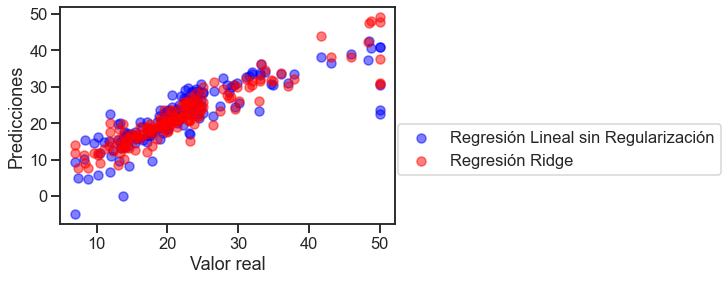

In [9]:
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
ax.scatter(y_test, y_pred_lr, alpha=.5, c='b', label=('Regresión Lineal sin Regularización'))
ax.scatter(y_test, y_pred_L2, alpha=.5, c='r', label=('Regresión Ridge'))

ax.set(xlabel='Valor real', 
       ylabel='Predicciones');
ax.legend(bbox_to_anchor=[2, 0.5])

In [10]:
grid_lr.best_estimator_[2].coef_

array([-1.16576115,  1.12036442,  0.68239408,  0.2831966 , -2.3213703 ,
        2.96011149, -0.30566034, -3.13440301,  2.39753515, -2.15253833,
       -1.94362785,  0.65567361, -3.39784996])

In [11]:
grid_L2.best_estimator_[2].coef_

array([-1.55200549e-01,  8.36502244e-02, -1.47596700e-01,  4.88876750e-02,
       -6.49320205e-01,  2.87608394e+00, -5.82603659e-01, -8.11276213e-01,
        2.61117862e-01, -6.47561793e-01, -7.46555948e-01,  4.05282909e-01,
       -2.52367350e+00,  7.29103020e-02,  3.88645527e-02,  2.19684828e-03,
        4.99793164e-01, -4.02597142e-01,  1.96661059e-01,  1.64227220e-01,
        2.22090702e-01, -4.17778222e-01,  1.75301630e-02, -5.22765126e-03,
       -2.57341860e-02, -3.44140043e-02,  2.39406801e-01, -2.36098149e-02,
        2.79765567e-01,  7.99250551e-02,  6.19973871e-02,  9.52130831e-02,
       -9.12130009e-02, -1.53438024e-01,  8.95510387e-02,  5.61776169e-02,
        5.31008267e-02,  8.61291842e-02,  3.77011778e-01,  7.31806686e-02,
        2.65709111e-01,  3.12808955e-01,  6.55482705e-01,  3.02792198e-01,
        7.49067470e-02,  3.96894985e-02, -2.88384303e-01,  6.85049113e-02,
       -6.03688066e-01,  1.72572736e-01, -4.88086700e-01, -4.89648958e-01,
        3.45887581e-01, -

## Regresión Logística: Primer ejemplo

Usaremos la base de datos de reconocimiento de actividad humana [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01) con teléfonos inteligentes, que se creó a partir de las grabaciones de los participantes del estudio que llevaban un teléfono inteligente con un sensor de inercia incorporado mientras realizaban actividades de la vida diaria (ADL). El objetivo es clasificar las actividades realizadas por los participantes en una de las seis categorías siguientes: caminar, subir escaleras, bajar escaleras, sentarse, pararse y acostarse.

La siguiente información se proporciona para cada registro en el conjunto de datos:

* Aceleración triaxial del acelerómetro (aceleración total) y la aceleración corporal estimada
* Velocidad angular triaxial del giroscopio
* Un vector de 561 características con variables de dominio de tiempo y frecuencia
* La etiqueta de actividad

In [12]:
%time data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/Human_Activity_Recognition_Using_Smartphones_Data.csv", sep=',')

CPU times: total: 1.86 s
Wall time: 25.5 s


In [13]:
data.shape

(10299, 562)

In [14]:
data.shape[0]*data.shape[1]

5788038

In [15]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,...,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000
mean,0.274347,-0.017743,-0.108925,-0.607784,-0.510191,-0.613064,-0.633593,-0.525697,-0.614989,-0.466732,...,0.126708,-0.298592,-0.617700,0.007705,0.002648,0.017683,-0.009219,-0.496522,0.063255,-0.054284
std,0.067628,0.037128,0.053033,0.438694,0.500240,0.403657,0.413333,0.484201,0.399034,0.538707,...,0.245443,0.320199,0.308796,0.336591,0.447364,0.616188,0.484770,0.511158,0.305468,0.268898
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262625,-0.024902,-0.121019,-0.992360,-0.976990,-0.979137,-0.993293,-0.977017,-0.979064,-0.935788,...,-0.019481,-0.536174,-0.841847,-0.124694,-0.287031,-0.493108,-0.389041,-0.817288,0.002151,-0.131880
50%,0.277174,-0.017162,-0.108596,-0.943030,-0.835032,-0.850773,-0.948244,-0.843670,-0.845068,-0.874825,...,0.136245,-0.335160,-0.703402,0.008146,0.007668,0.017192,-0.007186,-0.715631,0.182028,-0.003882
75%,0.288354,-0.010625,-0.097589,-0.250293,-0.057336,-0.278737,-0.302033,-0.087405,-0.288149,-0.014641,...,0.288960,-0.113167,-0.487981,0.149005,0.291490,0.536137,0.365996,-0.521503,0.250790,0.102970
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

LAYING                0.188756
STANDING              0.185067
SITTING               0.172541
WALKING               0.167201
WALKING_UPSTAIRS      0.149917
WALKING_DOWNSTAIRS    0.136518
Name: Activity, dtype: float64

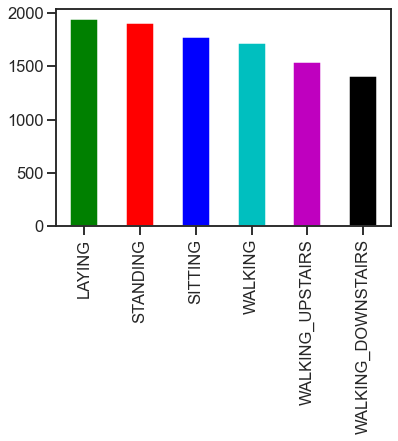

In [18]:
data.Activity.value_counts().plot.bar(color=['green', 'red', 'blue', 'c', 'm', 'k'])
data.Activity.value_counts(normalize=True)

In [19]:
le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(10)

5766    0
2988    3
3418    4
3849    1
6348    0
5500    2
6878    0
4334    4
1804    1
5854    4
Name: Activity, dtype: int32

In [20]:
feature_cols = data.columns[:-1]
correlacion = data[feature_cols].corr()

In [21]:
correlacion

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
tBodyAcc-mean()-X,1.000000,0.128037,-0.230302,0.004590,-0.016785,-0.036071,0.010303,-0.017488,-0.038805,0.046943,...,0.029901,-0.006179,-0.002255,-0.552989,0.015754,0.036047,0.034296,-0.041021,0.034053,0.030656
tBodyAcc-mean()-Y,0.128037,1.000000,-0.029882,-0.046352,-0.046996,-0.054153,-0.045247,-0.047673,-0.055524,-0.039445,...,-0.014402,-0.000649,-0.002842,0.077750,-0.027567,0.013241,0.077627,-0.007513,-0.005616,-0.016233
tBodyAcc-mean()-Z,-0.230302,-0.029882,1.000000,-0.024185,-0.023745,-0.015632,-0.022872,-0.022966,-0.009577,-0.040218,...,-0.015358,0.023050,0.023122,0.055020,-0.042083,-0.066233,-0.030748,0.003215,-0.012986,-0.028406
tBodyAcc-std()-X,0.004590,-0.046352,-0.024185,1.000000,0.922525,0.861910,0.998662,0.916087,0.856497,0.981226,...,-0.068807,0.165552,0.135171,-0.034334,-0.017096,0.027464,-0.027123,-0.374104,0.449425,0.393063
tBodyAcc-std()-Y,-0.016785,-0.046996,-0.023745,0.922525,1.000000,0.888259,0.918561,0.997510,0.887052,0.911137,...,-0.109941,0.220279,0.191164,-0.020806,-0.006605,0.001902,-0.015784,-0.381391,0.506106,0.425511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"angle(tBodyGyroMean,gravityMean)",0.036047,0.013241,-0.066233,0.027464,0.001902,-0.004984,0.027729,-0.002924,-0.009873,0.033533,...,-0.029273,0.042123,0.035684,-0.013009,0.010679,1.000000,-0.112454,-0.007095,-0.006444,-0.015380
"angle(tBodyGyroJerkMean,gravityMean)",0.034296,0.077627,-0.030748,-0.027123,-0.015784,-0.012196,-0.027097,-0.013411,-0.012800,-0.030908,...,-0.002618,-0.013065,-0.011829,-0.027478,0.023605,-0.112454,1.000000,0.024822,-0.004582,-0.012549
"angle(X,gravityMean)",-0.041021,-0.007513,0.003215,-0.374104,-0.381391,-0.353271,-0.371168,-0.378013,-0.355836,-0.384244,...,0.087571,-0.085226,-0.081971,0.008050,0.017534,-0.007095,0.024822,1.000000,-0.748249,-0.635231
"angle(Y,gravityMean)",0.034053,-0.005616,-0.012986,0.449425,0.506106,0.459092,0.444926,0.507947,0.460345,0.458832,...,-0.105752,0.087671,0.078010,0.003082,-0.007256,-0.006444,-0.004582,-0.748249,1.000000,0.545614


### Otra forma de hacerlo

In [12]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Selecciona los índices de la triangular inferior para luego hacer los valores igual a np.NaN
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

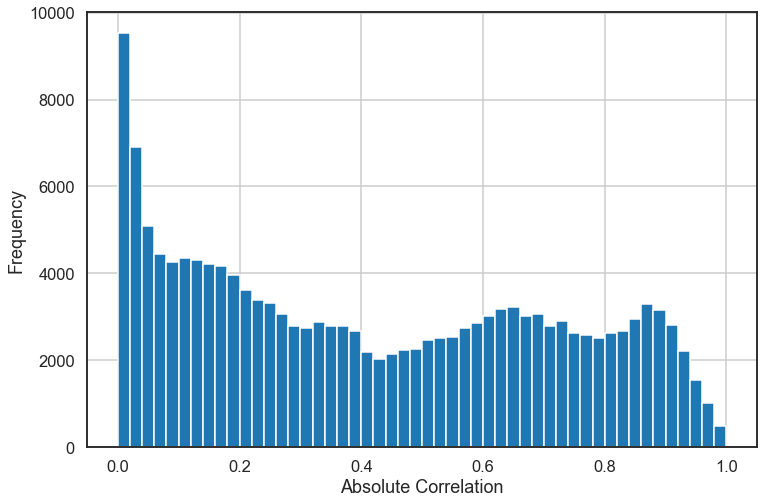

In [14]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [15]:
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


### Seguimos con el código

In [24]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [25]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [26]:
# Standard logistic regression
%time lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

CPU times: total: 7.06 s
Wall time: 7.13 s


In [20]:
%time lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear', verbose=1, n_jobs=-1).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  3.6min finished


CPU times: total: 9.77 s
Wall time: 3min 43s


In [23]:
pickle.dump(lr_l1, open('Modelo_reg_log_Lasso.p', 'wb'))
LASSO = pickle.load(open('Modelo_reg_log_Lasso.p', 'rb'))

In [30]:
(lr_l1.predict(X_test)==LASSO.predict(X_test)).all()

True

In [31]:
%time lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear', verbose=1, n_jobs=-1).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.1min finished


CPU times: total: 8.44 s
Wall time: 2min 16s


In [32]:
%time gs = GridSearchCV(LogisticRegression(max_iter=10000, tol=0.1), param_grid = {"C": np.logspace(-4,4,10)}, verbose=1, n_jobs=-1)

CPU times: total: 0 ns
Wall time: 5 ms


In [33]:
%time gs.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 1min 18s
Wall time: 3min 33s


GridSearchCV(estimator=LogisticRegression(max_iter=10000, tol=0.1), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])},
             verbose=1)

In [34]:
pickle.dump(lr_l2, open('Modelo_reg_log_Ridge.p', 'wb'))
pickle.dump(gs, open('Modelo_reg_log_GS.p', 'wb'))

In [27]:
LASSO = pickle.load(open('Modelo_reg_log_Lasso.p', 'rb'))
RIDGE = pickle.load(open('Modelo_reg_log_Ridge.p', 'rb'))
GS = pickle.load(open('Modelo_reg_log_GS.p', 'rb'))

In [28]:
GS.best_params_

{'C': 2.782559402207126}

In [29]:
LASSO.C_

array([166.81005372,   2.7825594 ,   2.7825594 ,   2.7825594 ,
        21.5443469 ,  21.5443469 ])

In [30]:
RIDGE.C_

array([  166.81005372,    21.5443469 ,    21.5443469 ,   166.81005372,
          21.5443469 , 10000.        ])

In [31]:
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2', 'gs']
coeff_models = [lr, LASSO, RIDGE, GS]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.sample(10, random_state=12)

,lr,l1,l2,gs
939,4,4,4,4
436,3,3,3,3
229,1,1,1,1
1197,4,4,4,4
667,2,2,2,2
2663,3,3,3,3
2642,0,0,0,0
1818,5,5,5,5
1649,2,2,2,2
907,2,2,2,2


In [40]:
y_prob.sample(15, random_state=12)

,lr,l1,l2,gs
939,0.945177,0.987630,0.999404,0.987730
436,0.984570,0.997101,0.999995,0.999982
229,0.997852,0.999971,0.999991,0.998908
1197,0.999603,0.999961,1.000000,0.999992
667,0.993621,0.997838,0.999853,0.999958
2663,0.988126,0.999019,0.999982,0.999008
2642,0.999727,1.000000,1.000000,0.999935
1818,0.989670,0.999434,0.999959,0.999904
1649,0.983926,0.997762,0.999622,0.999168
907,0.990353,0.999391,0.999696,0.999144


In [41]:
metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)
metrics

,lr,l1,l2,gs
precision,0.984144,0.983833,0.984477,0.984148
recall,0.984142,0.983819,0.984466,0.984142
fscore,0.984143,0.983817,0.984464,0.984142
accuracy,0.984142,0.983819,0.984466,0.984142
auc,0.990384,0.990148,0.990553,0.990369


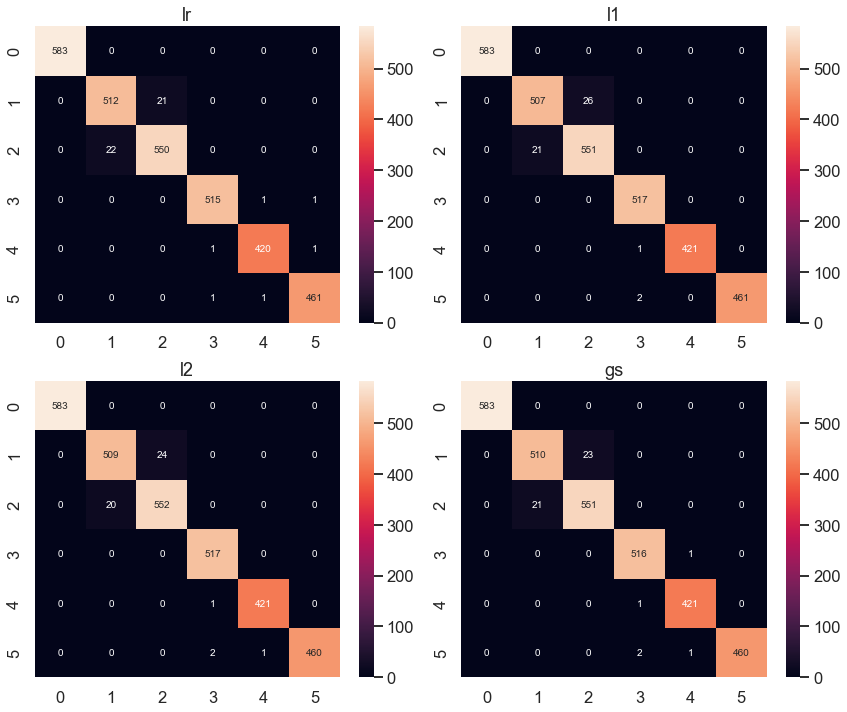

In [42]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

#axList[-1].axis('off')

for ax,lab in zip(axList[:], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

## Regresión Logistica: Ejemplo 2

In [3]:
# Load the dataset
dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/food_items.csv"
food_df = pd.read_csv(dataset_url)

In [4]:
food_df.dtypes

Calories               float64
Total Fat                int64
Saturated Fat          float64
Monounsaturated Fat    float64
Polyunsaturated Fat    float64
Trans Fat              float64
Cholesterol              int64
Sodium                 float64
Total Carbohydrate     float64
Dietary Fiber          float64
Sugars                 float64
Sugar Alcohol            int64
Protein                float64
Vitamin A                int64
Vitamin C                int64
Calcium                  int64
Iron                     int64
class                   object
dtype: object

In [6]:
food_df.sample(10)

,Calories,Total Fat,Saturated Fat,Monounsaturated Fat,Polyunsaturated Fat,Trans Fat,Cholesterol,Sodium,Total Carbohydrate,Dietary Fiber,Sugars,Sugar Alcohol,Protein,Vitamin A,Vitamin C,Calcium,Iron,class
10302,15.0,0,0.0,0.0,0.0,0.0,0,360.0,4.0,0.0,0.0,0,0.0,0,0,0,2,'In Moderation'
5068,180.0,4,1.5,1.0,0.0,0.5,0,280.0,34.0,0.0,19.0,0,1.0,0,0,8,6,'Less Often'
3397,190.0,7,1.0,0.0,0.0,0.0,0,170.0,29.0,2.0,12.0,0,4.0,0,0,0,4,'In Moderation'
8041,360.0,12,4.0,0.0,0.0,0.0,35,800.0,44.0,0.0,7.0,0,18.0,6,0,10,6,'In Moderation'
6165,50.0,2,0.0,0.0,0.0,0.0,5,290.0,9.0,0.0,5.0,0,0.0,0,0,0,0,'In Moderation'
12406,90.0,2,0.0,1.0,1.0,0.0,0,330.0,4.0,2.0,0.0,0,14.0,4,0,8,30,'In Moderation'
2795,80.0,1,0.0,0.0,0.0,0.0,10,660.0,12.0,2.0,4.0,0,7.0,15,0,2,4,'In Moderation'
3837,60.0,0,0.0,0.0,0.0,0.0,0,0.0,11.0,1.0,0.0,0,2.0,0,0,0,25,'In Moderation'
8523,175.0,9,3.5,0.0,0.0,0.0,60,60.0,0.0,0.0,0.0,0,24.0,0,0,0,0,'Less Often'
4185,80.0,0,0.0,0.0,0.0,0.0,0,60.0,6.0,0.0,6.0,0,15.0,0,0,20,0,'In Moderation'


In [7]:
feature_cols = list(food_df.iloc[:, :-1].columns)
feature_cols

['Calories',
 'Total Fat',
 'Saturated Fat',
 'Monounsaturated Fat',
 'Polyunsaturated Fat',
 'Trans Fat',
 'Cholesterol',
 'Sodium',
 'Total Carbohydrate',
 'Dietary Fiber',
 'Sugars',
 'Sugar Alcohol',
 'Protein',
 'Vitamin A',
 'Vitamin C',
 'Calcium',
 'Iron']

In [8]:
food_df.iloc[:, :-1].describe()

,Calories,Total Fat,Saturated Fat,Monounsaturated Fat,Polyunsaturated Fat,Trans Fat,Cholesterol,Sodium,Total Carbohydrate,Dietary Fiber,Sugars,Sugar Alcohol,Protein,Vitamin A,Vitamin C,Calcium,Iron
count,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000
mean,133.861086,4.475264,1.450617,0.338069,0.254660,0.047459,8.857692,241.867142,18.232020,1.602971,6.645234,0.117949,4.661333,6.287632,6.741855,5.175264,5.235671
std,94.227650,5.386340,2.410318,1.345852,2.230586,0.321402,20.976530,272.284363,14.786316,3.363879,8.328465,1.121529,5.611143,18.374191,23.785100,8.779637,9.119459
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,120.000000,3.000000,0.500000,0.000000,0.000000,0.000000,0.000000,135.000000,17.000000,1.000000,3.000000,0.000000,3.000000,0.000000,0.000000,2.000000,2.000000
75%,180.000000,7.000000,2.000000,0.000000,0.000000,0.000000,10.000000,370.000000,27.000000,2.000000,11.000000,0.000000,7.000000,6.000000,2.000000,6.000000,8.000000
max,2210.000000,43.000000,22.000000,40.000000,235.000000,11.000000,450.000000,2431.000000,270.000000,305.000000,115.000000,31.000000,70.000000,622.000000,1000.000000,110.000000,170.000000


<AxesSubplot:xlabel='class'>

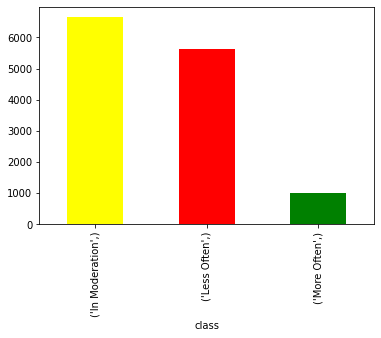

In [9]:
food_df.iloc[:, -1:].value_counts(normalize=True)
food_df.iloc[:, -1:].value_counts().plot.bar(color=['yellow', 'red', 'green'])

### Ingenieria de características

In [11]:
X_raw = food_df.iloc[:, :-1]
y_raw = food_df.iloc[:, -1:]
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)
pd.DataFrame(X,columns=feature_cols).describe()

,Calories,Total Fat,Saturated Fat,Monounsaturated Fat,Polyunsaturated Fat,Trans Fat,Cholesterol,Sodium,Total Carbohydrate,Dietary Fiber,Sugars,Sugar Alcohol,Protein,Vitamin A,Vitamin C,Calcium,Iron
count,1.326000e+04,1.326000e+04,1.326000e+04,1.326000e+04,1.326000e+04,1.326000e+04,1.326000e+04,1.326000e+04,1.326000e+04,1.326000e+04,1.326000e+04,1.326000e+04,1.326000e+04,1.326000e+04,1.326000e+04,1.326000e+04,1.326000e+04
mean,7.716301e-17,-1.714734e-17,-5.144201e-17,5.358543e-18,1.286050e-17,1.286050e-17,3.429467e-17,1.714734e-17,-1.050274e-16,-3.858151e-17,3.429467e-17,-4.286834e-18,-4.286834e-17,-1.714734e-17,3.429467e-17,-5.144201e-17,4.286834e-18
std,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00
min,-1.420667e+00,-8.308856e-01,-6.018590e-01,-2.512031e-01,-1.141714e-01,-1.476665e-01,-4.222827e-01,-8.883223e-01,-1.233080e+00,-4.765426e-01,-7.979243e-01,-1.051718e-01,-8.307592e-01,-3.422120e-01,-2.834594e-01,-5.894844e-01,-5.741425e-01
25%,-6.777575e-01,-8.308856e-01,-6.018590e-01,-2.512031e-01,-1.141714e-01,-1.476665e-01,-4.222827e-01,-7.414115e-01,-8.949165e-01,-4.765426e-01,-7.979243e-01,-1.051718e-01,-6.525356e-01,-3.422120e-01,-2.834594e-01,-5.894844e-01,-5.741425e-01
50%,-1.471077e-01,-2.739002e-01,-3.944097e-01,-2.512031e-01,-1.141714e-01,-1.476665e-01,-4.222827e-01,-3.924984e-01,-8.332475e-02,-1.792556e-01,-4.377002e-01,-1.051718e-01,-2.960886e-01,-3.422120e-01,-2.834594e-01,-3.616759e-01,-3.548229e-01
75%,4.896721e-01,4.687471e-01,2.279383e-01,-2.512031e-01,-1.141714e-01,-1.476665e-01,5.445852e-02,4.706025e-01,5.930017e-01,1.180315e-01,5.228971e-01,-1.051718e-01,4.168056e-01,-1.565472e-02,-1.993699e-01,9.394091e-02,3.031356e-01
max,2.203405e+01,7.152572e+00,8.525912e+00,2.947087e+01,1.052433e+02,3.407868e+01,2.103107e+01,8.040180e+00,1.702773e+01,9.019601e+01,1.301066e+01,2.753671e+01,1.164489e+01,3.351089e+01,4.176125e+01,1.193998e+01,1.806802e+01


In [13]:
y_raw.values.ravel()

array(["'In Moderation'", "'In Moderation'", "'In Moderation'", ...,
       "'In Moderation'", "'In Moderation'", "'In Moderation'"],
      dtype=object)

In [15]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw.values.ravel())

`0=In Moderation`, `1=Less Often`, `2=More Often`

In [16]:
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([6649, 5621,  990], dtype=int64))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 123)

penalty= 'l2'
multi_class = 'multinomial'
solver = 'lbfgs'
max_iter = 1000

l2_model = LogisticRegression(random_state=123, penalty=penalty, multi_class=multi_class, solver=solver, max_iter=max_iter)
l2_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=123)

In [18]:
l2_preds = l2_model.predict(X_test)

In [19]:
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = score(yt, yp)
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

In [20]:
evaluate_metrics(y_test, l2_preds)

{'accuracy': 0.8125942684766214,
 'recall': array([0.85338346, 0.75      , 0.89393939]),
 'precision': array([0.79426172, 0.83797217, 0.8156682 ]),
 'f1score': array([0.82276187, 0.7915493 , 0.85301205])}

In [21]:
penalty= 'l1'
multi_class = 'multinomial'
solver = 'saga'
max_iter = 1000
l1_model = LogisticRegression(random_state=123, penalty=penalty, multi_class=multi_class, solver=solver, max_iter = max_iter)
l1_model.fit(X_train, y_train);
l1_preds = l1_model.predict(X_test)
evaluate_metrics(y_test, l1_preds)

{'accuracy': 0.8141025641025641,
 'recall': array([0.85714286, 0.74822064, 0.8989899 ]),
 'precision': array([0.7966457 , 0.83932136, 0.81278539]),
 'f1score': array([0.82578776, 0.7911571 , 0.85371703])}

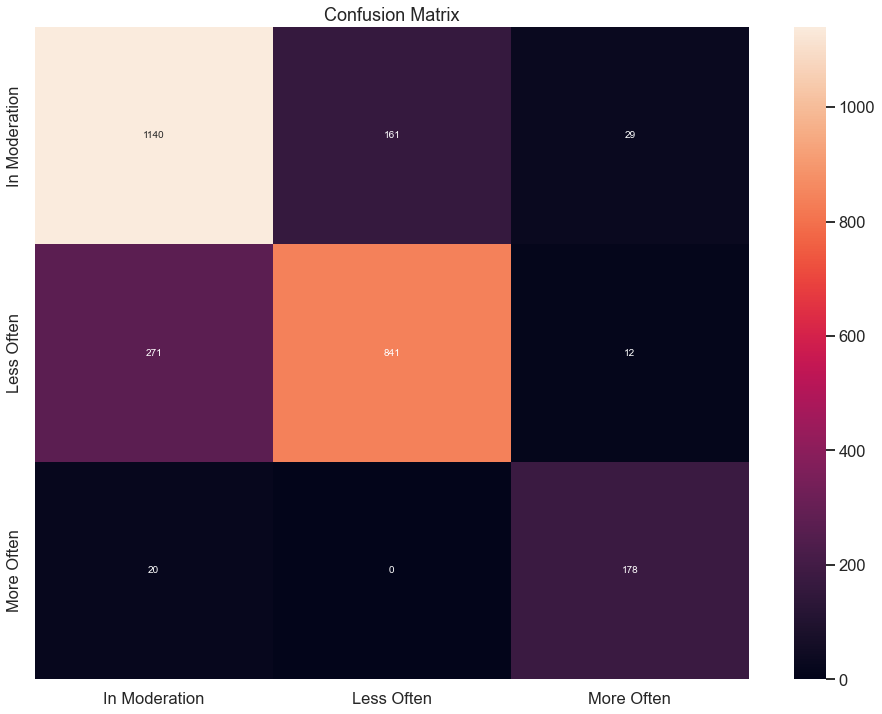

In [58]:
cf = confusion_matrix(y_test, l1_preds)
plt.figure(figsize=(16, 12))
ax = sns.heatmap(cf, annot=True, fmt="d", xticklabels=["In Moderation", "Less Often", "More Often"], 
                 yticklabels=["In Moderation", "Less Often", "More Often"])
ax.set(title="Confusion Matrix");

In [22]:
def get_feature_coefs(regression_model, label_index, columns):
    coef_dict = {}
    for coef, feat in zip(regression_model.coef_[label_index, :], columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = coef
    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):
    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')
    return color_vals

# Visualize coefficients
def visualize_coefs(coef_dict):
    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('')
    plt.show()

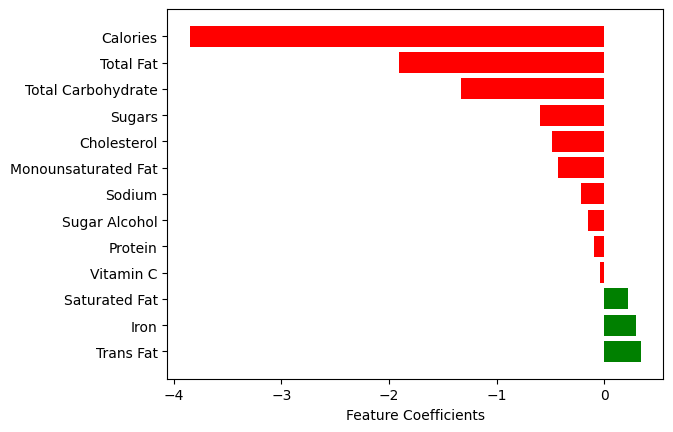

In [26]:
coef_dict = get_feature_coefs(l1_model, 2, feature_cols)
visualize_coefs(coef_dict)

In [27]:
len(feature_cols)

17

In [77]:
rfeMod = RFE(LogisticRegression(random_state=123, penalty=penalty, multi_class=multi_class, solver=solver, max_iter=max_iter),n_features_to_select=7)

%time rfeMod.fit(X_train,y_train)


CPU times: total: 59.8 s
Wall time: 59.9 s


RFE(estimator=LogisticRegression(max_iter=1000, multi_class='multinomial',
                                 penalty='l1', random_state=123,
                                 solver='saga'),
    n_features_to_select=7)

In [81]:
rfeMod.support_

array([ True,  True,  True, False, False, False,  True, False,  True,
        True,  True, False, False, False, False, False, False])

In [82]:
rfeMod.ranking_

array([ 1,  1,  1,  2,  9,  3,  1,  6,  1,  1,  1,  7,  4, 10, 11,  8,  5])

In [93]:
pd.Series(feature_cols)[rfeMod.support_].values

array(['Calories', 'Total Fat', 'Saturated Fat', 'Cholesterol',
       'Total Carbohydrate', 'Dietary Fiber', 'Sugars'], dtype=object)

In [94]:
y_pred_rfe = rfeMod.predict(X_test)
evaluate_metrics(y_test, y_pred_rfe)

{'accuracy': 0.8069381598793364,
 'recall': array([0.84360902, 0.74021352, 0.93939394]),
 'precision': array([0.79237288, 0.82376238, 0.82300885]),
 'f1score': array([0.81718864, 0.77975633, 0.87735849])}

In [95]:
evaluate_metrics(y_test, l1_preds)

{'accuracy': 0.8141025641025641,
 'recall': array([0.85714286, 0.74822064, 0.8989899 ]),
 'precision': array([0.7966457 , 0.83932136, 0.81278539]),
 'f1score': array([0.82578776, 0.7911571 , 0.85371703])}

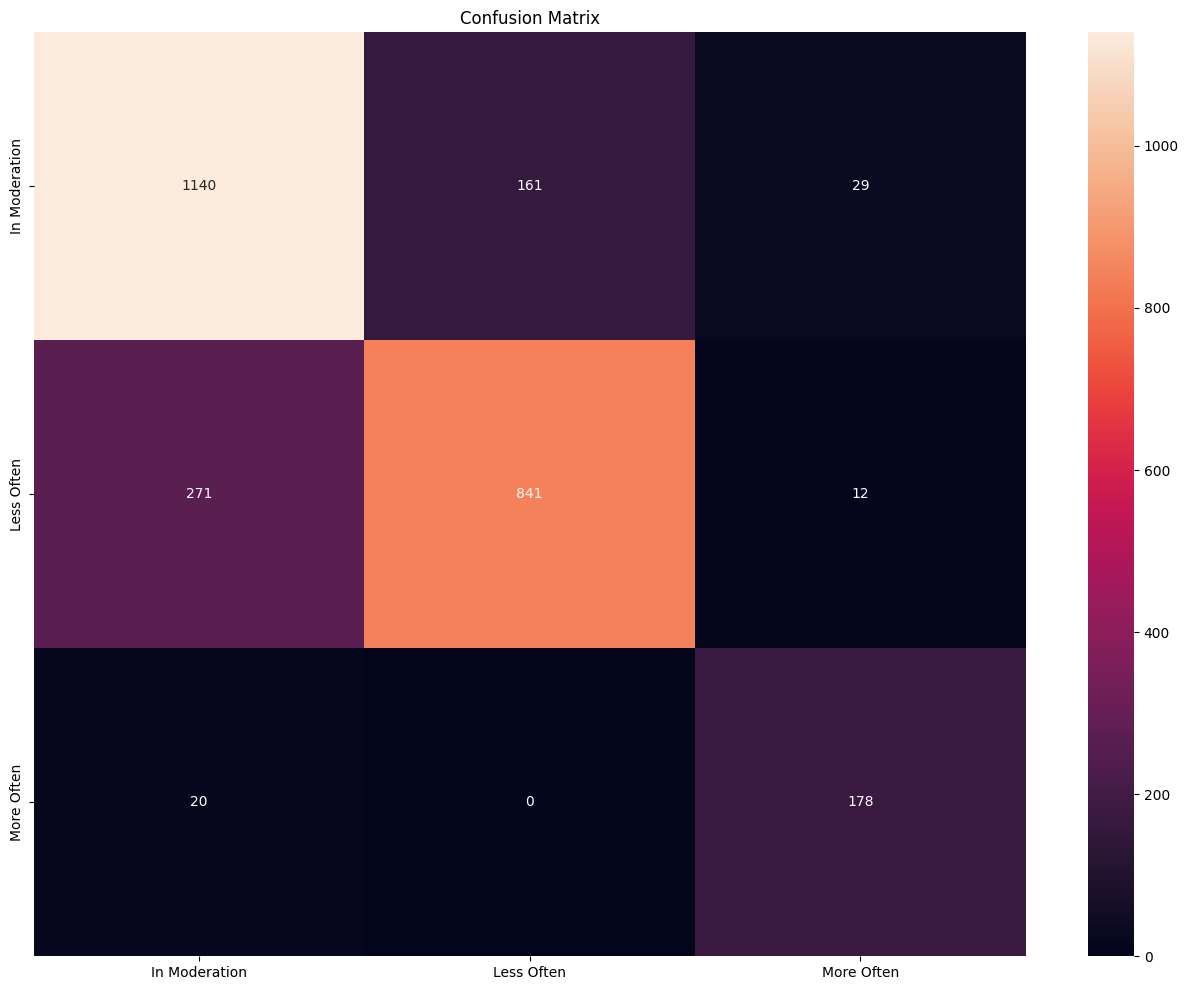

In [96]:
cf = confusion_matrix(y_test, l1_preds)
plt.figure(figsize=(16, 12))
ax = sns.heatmap(cf, annot=True, fmt="d", xticklabels=["In Moderation", "Less Often", "More Often"], 
                 yticklabels=["In Moderation", "Less Often", "More Often"])
ax.set(title="Confusion Matrix");